In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from NCP.cdf import get_cdf
from NCP.examples.tools.plot_utils import plot_expectation, setup_plots
from NCP.metrics import hellinger, kullback_leibler
from NCP.model import NCPModule, NCPOperator
from NCP.nn.callbacks import LitProgressBar
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.mysc.utils import from_np, smooth_cdf

setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Heteroscedastic

We study the ability of our method to learn conditional distributions using the following toy example:
$ Y \sim \mathcal{N}(X^2, 1+\vert X \vert)$

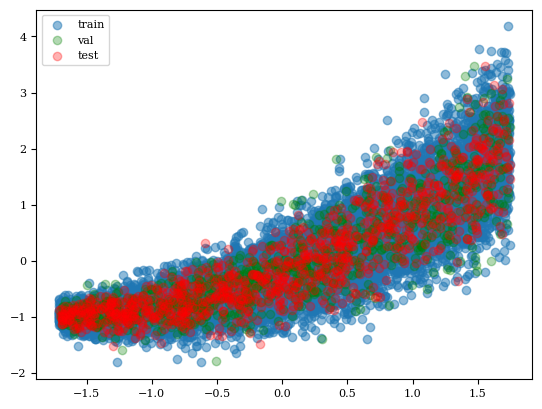

In [20]:
norm_noise = lambda x : norm.rvs(loc=0, scale=x)
X_train, X_test, X_val, Y_val, Y_train, Y_test, xscaler, yscaler = gen_additive_noise_data(norm_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

We train our model using two MLP for $U_\theta$ and $V_\theta$.

epoch = 9999, loss = -1.6499626636505127: 100%|██████████| 10000/10000 [04:11<00:00, 39.69it/s]


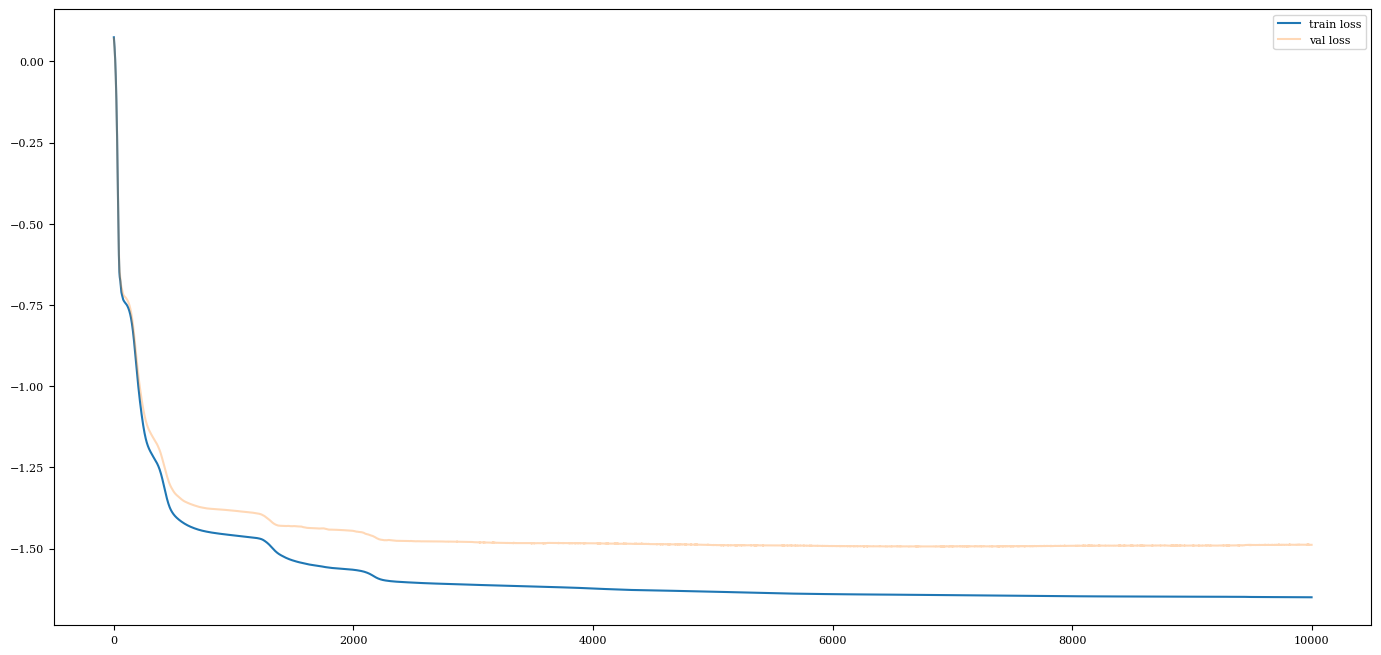

In [21]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

reg.fit(X_train, Y_train, X_val, Y_val, epochs=int(1e4), optimizer=optimizer, optimizer_kwargs=optimizer_kwargs)

ls = reg.get_losses()
plt.figure(figsize=(17, 8))
plt.plot(range(len(ls)), np.array(ls))
plt.plot(range(len(ls)), np.array(reg.get_val_losses()), alpha=0.3)
# plt.yscale('log')
plt.show()


X_train_torch = from_np(X_train)
Y_train_torch = from_np(Y_train)
X_val_torch = from_np(X_val)
Y_val_torch = from_np(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

As we can see, the loss converges. Let us first verify that we are able to predict the expectation of the model:

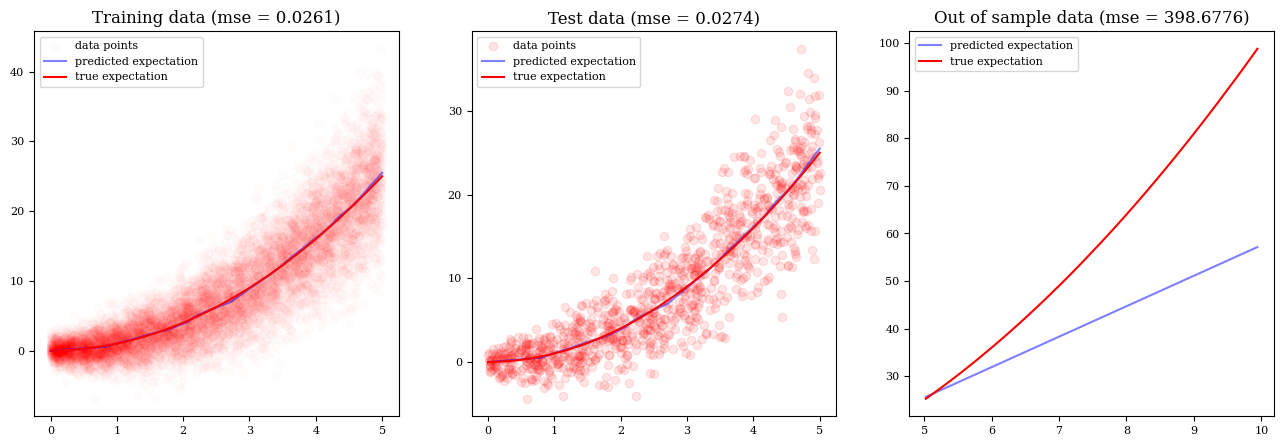

In [22]:
plot_expectation(reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

Let us now examine the CDF for varying values of X:

result for x= 0
- KL: 0.589035010288748
- Hellinger: 0.23775540481030788
result for x= 1
- KL: 0.5832748381314348
- Hellinger: 0.23499864527931594
result for x= 3
- KL: 0.5669712136010416
- Hellinger: 0.2274291047502205
result for x= 7
- KL: 3.892876033039597
- Hellinger: 0.7291978453990987


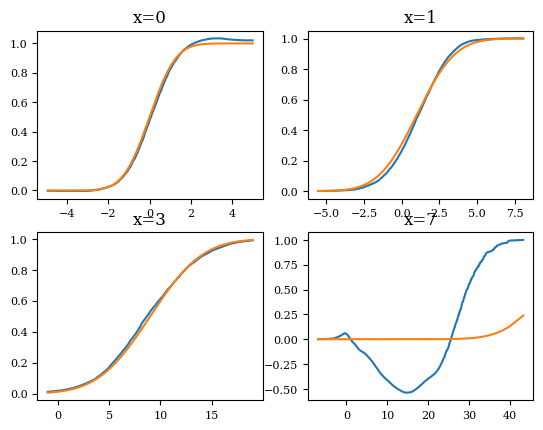

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 7]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='centering')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = norm.cdf(fys, loc=xi**2, scale=1+np.abs(xi))

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()

Now with whitening:

result for x= 0
- KL: 0.589035010288748
- Hellinger: 0.23775540481030788
result for x= 1
- KL: 0.5832748381314348
- Hellinger: 0.23499864527931594
result for x= 3
- KL: 0.5669712136010416
- Hellinger: 0.2274291047502205
result for x= 7
- KL: 3.892876033039597
- Hellinger: 0.7291978453990987


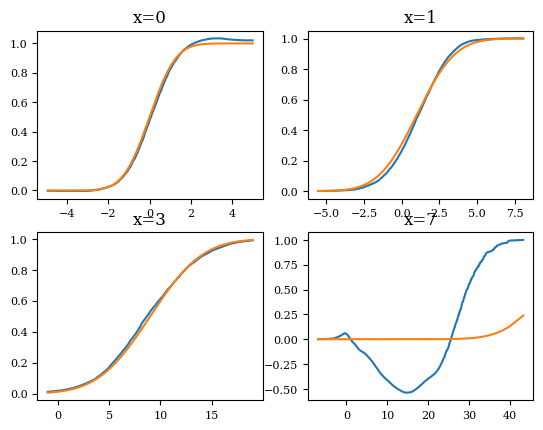

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 7]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, postprocess='whitening')
    cdf_pred_smooth = smooth_cdf(fys, cdf_pred)
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = norm.cdf(fys, loc=xi**2, scale=1+np.abs(xi))

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()

Effect of changing the Y marginal:

result for x= 5
- KL: 3.3290570794062577
- Hellinger: 0.8099191530804024
result for x= 6
- KL: 0.7946743555528359
- Hellinger: 0.28822277324638107
result for x= 7
- KL: 1.2636619778688267
- Hellinger: 0.4676175582692358
result for x= 9
- KL: 8.897013773134555
- Hellinger: 0.927952298045563


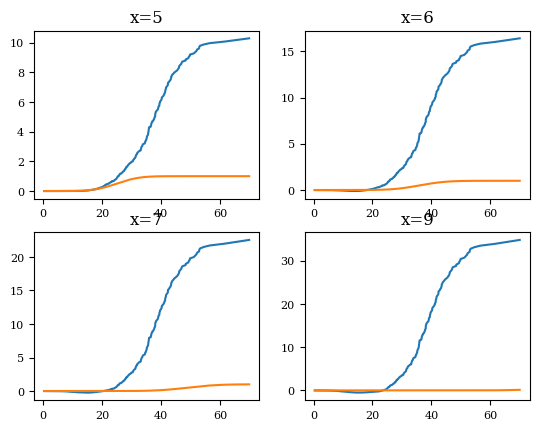

In [25]:
X_oos = np.random.uniform(3,7, size=400)
Y_oos = np.zeros(X_oos.shape[0])
for i, xi in enumerate(X_oos):
    Y_oos[i] = xi**2 + np.random.normal(0, 1+xi)
Y_oos = yscaler.transform(Y_oos.reshape((-1, 1)))

X_test_oos = [5, 6, 7, 9]

fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate(X_test_oos):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(reg, x_scaled, Y=Y_oos, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = norm.cdf(fys, loc=xi**2, scale=1+np.abs(xi))

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()

Estimating moments of the conditional distribution

Text(0.5, 1.0, 'Test data (mse = 0.0274)')

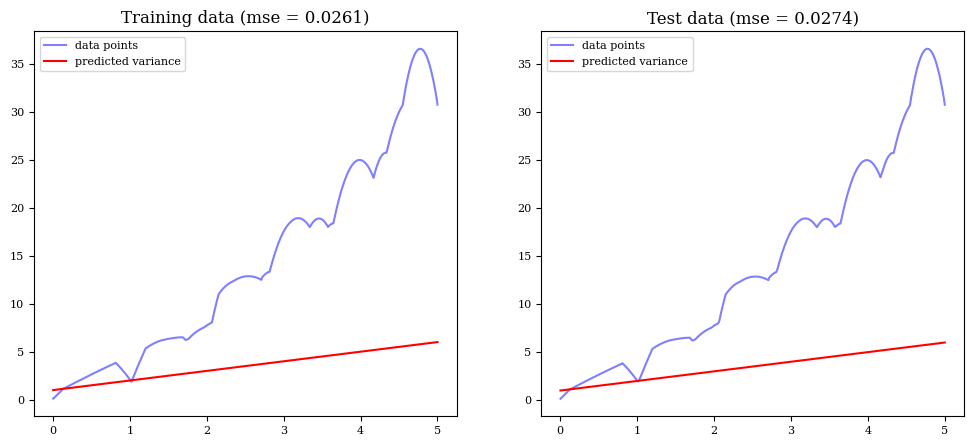

In [26]:
postprocess = 'whitening'

from sklearn.metrics import mean_squared_error

from NCP.cdf import compute_variance

var_pred = compute_variance(reg, X_train, postprocess=postprocess)
var_pred_test = compute_variance(reg, X_test, postprocess=postprocess)

transform_scale = yscaler.scale_

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axes = axs.flatten()

Xs = xscaler.inverse_transform(X_train)
sorted = np.argsort(Xs.flatten())
axes[0].plot(Xs.flatten()[sorted],
            (transform_scale**2) * var_pred.flatten()[sorted], 'b', alpha=0.5)
axes[0].plot(Xs.flatten()[sorted], 1+Xs.flatten()[sorted], 'red')
axes[0].legend(['predicted variance', 'true variance'])
axes[0].set_title(f'Training data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(var_pred)), 4)})')

Xs = xscaler.inverse_transform(X_test)
sorted = np.argsort(Xs.flatten())
axes[1].plot(Xs.flatten()[sorted],
            (transform_scale**2) * var_pred_test.flatten()[sorted], 'b', alpha=0.5)
axes[1].plot(Xs.flatten()[sorted], 1+Xs.flatten()[sorted], 'red')
axes[1].legend(['predicted variance', 'true variance'])
axes[1].set_title(f'Test data (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(var_pred_test)), 4)})')
